In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.append("..")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
import tonic
import torchvision
import tonic.transforms as transforms

transform = tonic.transforms.Compose(
    [
        transforms.ToFrame(n_time_bins=30, merge_polarities=True),
        tonic.transforms.NumpyAsType("float32"),
    ]
)

target_transform = tonic.transforms.Compose([transforms.ToOneHotEncoding(4)])

download = True
trainset = tonic.datasets.POKERDVS(
    save_to="../data", download=download, transform=transform, train=True
)
testset = tonic.datasets.POKERDVS(
    save_to="../data", download=download, transform=transform, train=False
)

Using downloaded and verified file: ../data/pips_train.tar.gz
Extracting ../data/pips_train.tar.gz to ../data
Using downloaded and verified file: ../data/pips_test.tar.gz
Extracting ../data/pips_test.tar.gz to ../data


<IPython.core.display.Javascript object>

In [5]:
no_classes = len(trainset.classes)
print(f"number of classes: {no_classes}")
trainset.classes

number of classes: 4


['cl', 'he', 'di', 'sp']

<IPython.core.display.Javascript object>

## Class Distribution

In [6]:
dis = np.unique(np.array(trainset.targets), return_counts=True)[1]
dis

array([12, 12, 12, 12])

<IPython.core.display.Javascript object>

In [7]:
events = trainset[0][0]
events.shape

(30, 1, 35, 35)

<IPython.core.display.Javascript object>

In [8]:
np.unique(events)

array([0., 1., 2., 3., 4., 5.], dtype=float32)

<IPython.core.display.Javascript object>

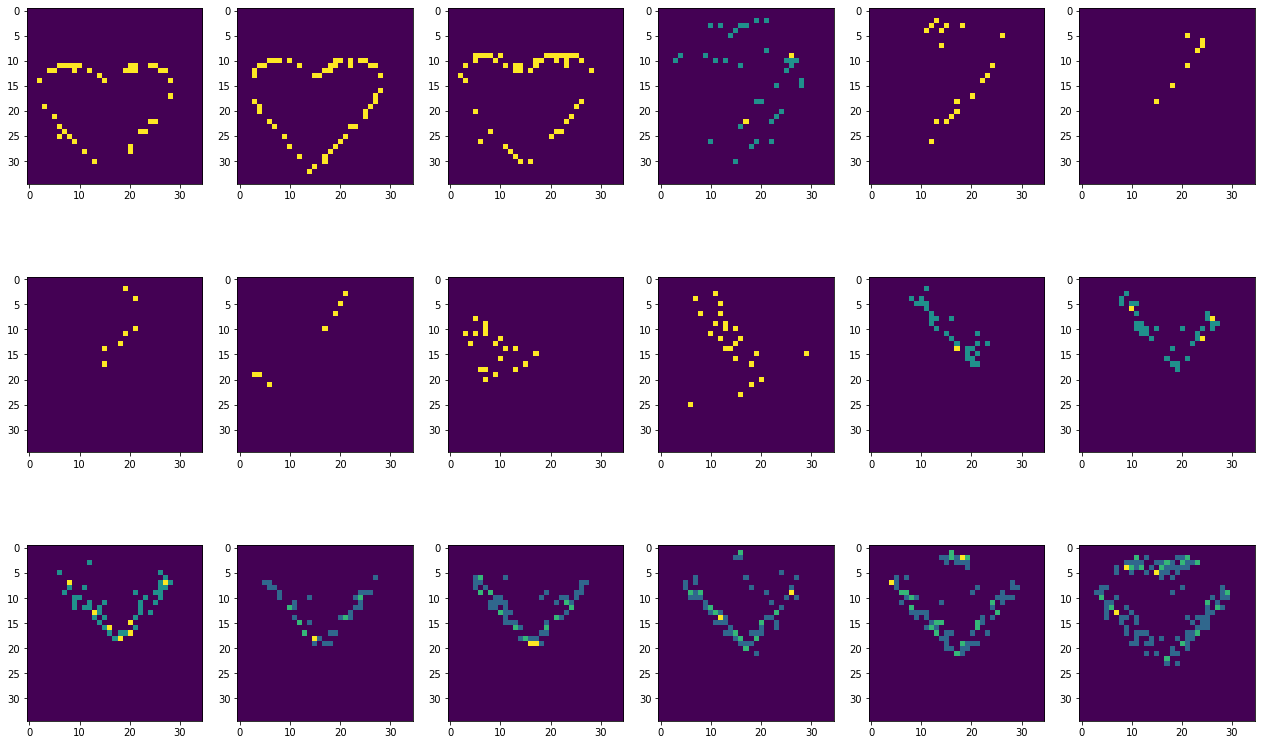

<IPython.core.display.Javascript object>

In [9]:
w = 10
h = 10
fig = plt.figure(figsize=(22, 14))
columns = 6
rows = 3
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(events[i, 0])
plt.show()

## Tensorflow 3D CNN

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Flatten

<IPython.core.display.Javascript object>

In [13]:
model = Sequential(
    [
        Conv3D(filters=64, kernel_size=(3, 3, 3), input_shape=(30, 35, 35, 1)),
        MaxPool3D((3, 3, 3)),
        Flatten(),
        Dense(128),
        Dense(64),
        Dense(32),
        Dense(4),
    ]
)

<IPython.core.display.Javascript object>

In [21]:
len(trainset.targets)

48

<IPython.core.display.Javascript object>

In [28]:
trainset[0]

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
   

<IPython.core.display.Javascript object>

## Create Dataloader

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

## Create Model

In [11]:
from tqdm.notebook import tqdm

In [12]:
class CNN3D(nn.Module):
    def __init__(self, output_features: int):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, (2, 2, 2), padding=(2, 2, 2))
        self.conv2 = nn.Conv3d(64, 128, (2, 2, 2), padding=(2, 2, 2))

        self.pool = nn.MaxPool3d((6, 2, 2))
        self.fc1 = nn.Linear(128 * 11 * 11, 60)
        self.fc2 = nn.Linear(60, output_features)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return x

In [13]:
EPOCHS = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

DEVICE = torch.device("cpu")

print(f"Running on {DEVICE}")

cnn = CNN3D(4).to(DEVICE)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

cnn.train()

for epoch in tqdm(range(EPOCHS)):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(DEVICE).permute((0, 2, 1, 3, 4))
        
        #labels = nn.functional.one_hot(labels, 4)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

print("Finished Training")

Running on cpu


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Finished Training


In [14]:
cnn.eval()

with torch.no_grad():
    test_loss = 0
    correct = 0

    outputs = []
    targets = []

    for data, target in tqdm(test_loader):
        # get the inputs; data is a list of [inputs, labels]

        data = data.to(DEVICE).permute((0, 2, 1, 3, 4))
        target = target.to(DEVICE)

        output = cnn(data)

        outputs.append(output)
        targets.append(target)

        test_loss += torch.nn.functional.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
print(f"Loss: {test_loss}")
print(f"Accuracy: {accuracy}")

Loss: -1.3495755195617676
Accuracy: 50.0
